##  <u> *Data Modelling*  </u>

In [ ]:
%run 3_EDA.ipynb

---

### <u>*Calssifications Modelling for gender as a Target Feature*</u>

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.metrics import (
    r2_score,accuracy_score,roc_auc_score,auc,roc_curve,precision_score,
    recall_score,precision_recall_curve,r2_score,classification_report,RocCurveDisplay,
    confusion_matrix,f1_score,ConfusionMatrixDisplay
    )

from sklearn.svm import SVR,SVC
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor,KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from catboost import CatBoostRegressor,CatBoostClassifier
from xgboost import XGBRegressor,XGBRFRegressor,XGBClassifier,XGBRFClassifier
import warnings
from catboost import CatBoostRegressor,CatBoostClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingRegressor,
    RandomForestClassifier,
    GradientBoostingClassifier
)

from hyperopt import fmin,tpe,STATUS_OK,Trials,hp
from sklearn.utils.multiclass import unique_labels
import plotclassification ,plotly
# import matplotlib.pyplot as plt
from yellowbrick.classifier import ClassificationReport

### *C.* <u>*gender as a Target Feature :*</u>

#### *C.1*<br> <u>*Basic Models Comparison :*</u>

##### *C.1.1*<br> <u>*Models :*</u>

In [14]:
models = {
                "Random Forest": RandomForestClassifier(),
                "Decision Tree": DecisionTreeClassifier(),
                "Gradient Boosting": GradientBoostingClassifier(),
                "XGBRegressor": XGBClassifier(),
                "CatBoosting Regressor": CatBoostClassifier(verbose=False),
                "AdaBoost Regressor": AdaBoostClassifier(),
            }

##### *C.1.2*<br> <u>*Prepare Date :*</u>

In [15]:
LabelEncoder_cat = LabelEncoder()
df_area=df.copy()
df_area["area"]=LabelEncoder_cat.fit_transform(df_area["area"])
x_area=df_area.drop("area",axis=1)
y_area= df_area["area"]



xtrain_full,xtest_full, ytrain, ytest = train_test_split(x_area, y_area, train_size=0.8, test_size=0.2,random_state=0)

numerical_cols = [col for col in xtrain_full.columns if xtrain_full[col].dtype in ['int64', 'float64']]
categorical_cols =[col for col in xtrain_full.columns if  xtrain_full[col].dtype == "object"]

my_cols = categorical_cols + numerical_cols
xtrain = xtrain_full[my_cols].copy()
xtest = xtest_full[my_cols].copy()

numerical_transformer = Pipeline(steps=[
    ("scaler",StandardScaler())
    ])


categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
    ("scaler",StandardScaler(with_mean=False))
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])



##### *C.1.3*<br> <u>*Apply Models :*</u>

In [16]:
def Cat_evaluate_model(true, predicted):
    AccuracyScore = accuracy_score(true, predicted)
    
    return AccuracyScore

###################################################

model_list = []
accurecy_list =[]
#mae_list=[]
#aucScore_list=[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    my_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
        ])
    
    my_pipeline.fit(xtrain, ytrain) 

    y_train_pred = my_pipeline.predict(xtrain)
    y_test_pred = my_pipeline.predict(xtest)

    model_train_AccuracyScore = Cat_evaluate_model(ytrain, y_train_pred)
    model_test_AccuracyScore = Cat_evaluate_model(ytest, y_test_pred)


    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Accuracy Score: {:.4f}".format(model_train_AccuracyScore))
    


    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Accuracy Score: {:.4f}".format(model_test_AccuracyScore))
   
 
    accurecy_list.append(model_test_AccuracyScore)
    #aucScore_list.append(model_test_aucScore)
    #mae_list.append(model_test_mae)
    
    print('='*35)
    print('\n')



Random Forest
Model performance for Training set
- Accuracy Score: 0.9896
----------------------------------
Model performance for Test set
- Accuracy Score: 0.2458


Decision Tree
Model performance for Training set
- Accuracy Score: 0.9896
----------------------------------
Model performance for Test set
- Accuracy Score: 0.2264


Gradient Boosting
Model performance for Training set
- Accuracy Score: 0.3215
----------------------------------
Model performance for Test set
- Accuracy Score: 0.3095


XGBRegressor
Model performance for Training set
- Accuracy Score: 0.4161
----------------------------------
Model performance for Test set
- Accuracy Score: 0.3032


CatBoosting Regressor
Model performance for Training set
- Accuracy Score: 0.3937
----------------------------------
Model performance for Test set
- Accuracy Score: 0.3023


AdaBoost Regressor
Model performance for Training set
- Accuracy Score: 0.3058
----------------------------------
Model performance for Test set
- Accurac

##### *C.1.4*<br> <u>*Best Model :*</u>

In [17]:
pd.DataFrame(list(zip(model_list,accurecy_list)), 
             columns=['Model Name', 'accurecy']).sort_values(by=["accurecy"],ascending=False)

,Model Name,accurecy
5,AdaBoost Regressor,0.310492
2,Gradient Boosting,0.309461
3,XGBRegressor,0.303198
4,CatBoosting Regressor,0.302314
0,Random Forest,0.245800
1,Decision Tree,0.226422


##### *C.1.5*<br> <u>*Apply Best Model :*</u>

In [18]:
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('melbourne', AdaBoostClassifier())# or ('melbourne_model', RandomForestRegressor(random_state=0,n_estimators=50)) 
                             ])
my_pipeline.fit(xtrain, ytrain)
preds = my_pipeline.predict(xtest)

##### *C.1.6*<br> <u>*classification_report - Best Model :*</u>

In [19]:
print(classification_report(ytest,preds))

              precision    recall  f1-score   support

           0       0.30      0.03      0.05      3214
           1       0.12      0.00      0.00      2623
           2       0.31      0.95      0.47      4179
           3       0.23      0.05      0.09      1622
           4       0.23      0.03      0.05      1180
           5       0.29      0.04      0.07       754

    accuracy                           0.31     13572
   macro avg       0.25      0.18      0.12     13572
weighted avg       0.25      0.31      0.18     13572



In [20]:
print("- Accuracy : ",
      accuracy_score(ytest, preds))
print('='*35)

print("- Precision Score \n (Positive Predictive Power) = True Positives / (True Positives + False Positives) :\n ", 
      precision_score(ytest, preds, average='weighted'))
print('='*35)
print("- Recall Score \n (True Positive Rate)  = True Positives / (True Positives + False Negatives) :\n ",
      recall_score(ytest, preds, average='weighted'))
print('='*35)
print("- F1-Score: ",
      f1_score(ytest, preds, average='weighted'))
print('='*35)
print("-Precision Score :")
print(f"The ratio of True Females amoung Predicted True Females {6233/(6233+3442)}")
print(f"The ratio of True Males amoung Predicted True Males {2447/(1450+2447)}")

print('='*35)
print("-recall Score :")
print(f"The ratio of True Females amoung all Females {6233/(6233+1450)}")
print(f"The ratio of True Males amoung all Males {2447/(3442+2447)}")
print('='*35)

- Accuracy :  0.3104921898025346
- Precision Score 
 (Positive Predictive Power) = True Positives / (True Positives + False Positives) :
  0.25460385886124853
- Recall Score 
 (True Positive Rate)  = True Positives / (True Positives + False Negatives) :
  0.3104921898025346
- F1-Score:  0.17569726141102124
-Precision Score :
The ratio of True Females amoung Predicted True Females 0.6442377260981912
The ratio of True Males amoung Predicted True Males 0.6279189119835771
-recall Score :
The ratio of True Females amoung all Females 0.8112716386828062
The ratio of True Males amoung all Males 0.4155204618780778


##### *C.1.7*<br> <u>*Visualize Best Model :*</u>

In [21]:
unique_labels(ytest)
labels=unique_labels(ytest)
col_names=[f"predicted{label}"for label in labels ]
index_names=[f"Actual{label}"for label in labels ]
pd.DataFrame(confusion_matrix(ytest, preds),columns=col_names,index=index_names)

,predicted0,predicted1,predicted2,predicted3,predicted4,predicted5
Actual0,83,2,3048,58,12,11
Actual1,49,1,2490,56,16,11
Actual2,76,2,3979,73,25,24
Actual3,32,3,1455,88,34,10
Actual4,23,0,1033,73,33,18
Actual5,16,0,643,43,22,30


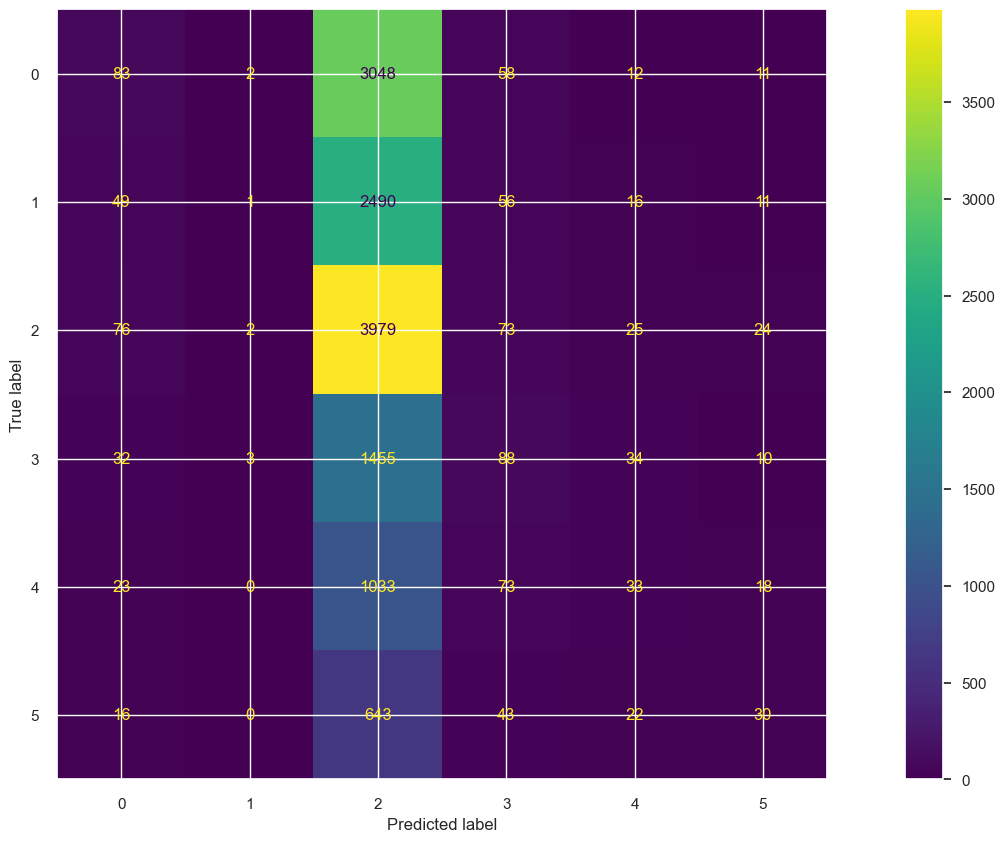

In [22]:
ConfusionMatrixDisplay(confusion_matrix(ytest,preds)).plot()

##### *C.1.8*<br> <u>*Visualize The classification_report :*</u>

In [25]:
classes = ['A','B','C','D','E','F']
visualizer = ClassificationReport(AdaBoostClassifier(), classes=classes, support=True)

AttributeError: 'Pipeline' object has no attribute 'show'

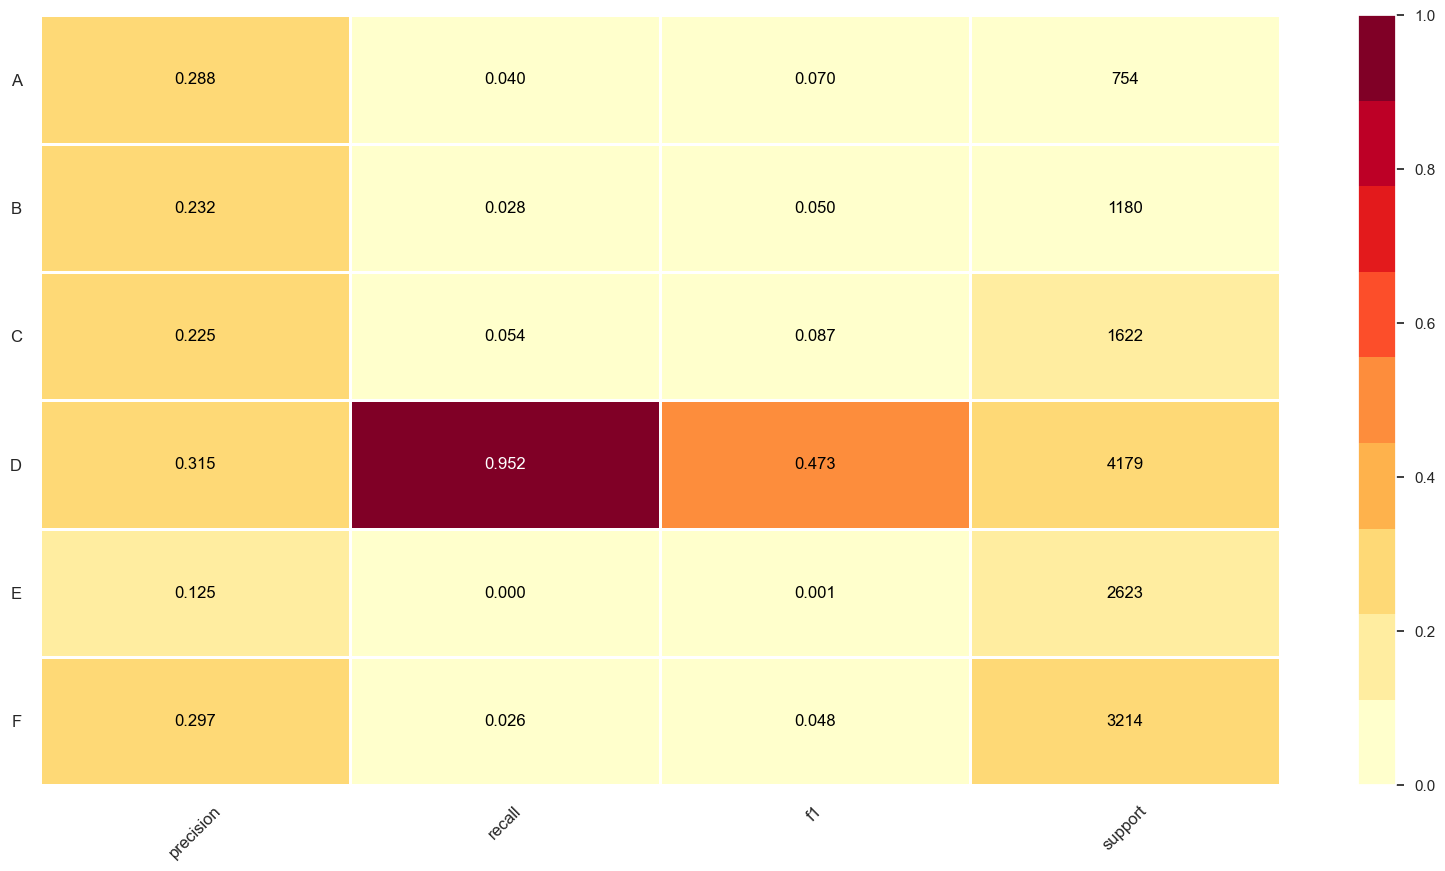

In [26]:
visualizer_Plot= Pipeline(steps=[('preprocessor', preprocessor),
                              ('melbourne_model', visualizer)# or ('melbourne_model', RandomForestRegressor(random_state=0,n_estimators=50)) 
                             ])
visualizer_Plot.fit(xtrain, ytrain)        # Fit the visualizer and the model
visualizer_Plot.score(xtest, ytest)        # Evaluate the model on the test data
visualizer_Plot.show()

##### *C.1.9*<br> <u>*ROC-CURVE :*</u>

* ##### *Area Under Curve (auc)*

In [30]:
auc = roc_auc_score(ytest, my_pipeline.predict_proba(xtest),multi_class="ovr")
#auc_0=roc_auc_score(ytest, my_pipeline.predict_proba(xtest)[:,1])
#auc_f=roc_auc_score(ytest, my_pipeline.predict_proba(xtest)[:,0])
print('AUC: %.3f' % auc)
#print('AUC for male Class : %.3f' % auc_m)
#print('AUC for Femal Class: %.3f' % auc_f)


AUC: 0.610


* ##### *Area Under Curve (auc) Visualization :*

### PrecisionRecallDisplay¶

----